# **Chap 9：对抗和生成**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from source.code import utils
from source.code import ch9

2023-12-26 13:32:51.058400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 13:32:51.191355: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 13:32:51.221933: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 13:32:51.879011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
utils.gpu_limitation_config(memory=30,device=2)

## **9.4 自编码器 AutoEncoder**

### **9.4.1 自编码器模型**

**自编码器**（**AutoEncoder**）神经网络是一类特殊的模型，它们尝试将其输入复制到其输出，**自编码器能够获取关于输入的隐藏表示**，具体地，模型由两部分组成：
* 一个**编码器函数**（**Encoder**）：$\mathbf{h} = f(\mathbf{x})$
* 一个**解码器函数**（**Decoder**）或者叫**重构器函数**（**Reconstructor**）：$\mathbf{r} = g(\mathbf{h})$，**它的输入是编码器的输出** $\mathbf{h}$


如果一个自编码器对任何样本 $\mathbf{x}$ 简单地学习了设置 $g(f(\mathbf{x})) = \mathbf{x}$（例如设置 $f,g$ 为两个恒等映射），那么该自编码器并没有实际用处；相反，自编码器通常无法学习完美复制，我们**更关心 $f$ 能否将原始输入 $\mathbf{x}$ 编码到低维的、更有效的隐藏表示**
* 通常自编码器会受到限制，只能近似复制样本 $\mathbf{x}$，这**迫使模型优先考虑应该复制输入的哪些方面，所以 $f$ 通常会捕获数据的有用成分**

传统上，**自编码器用于特征降维或特征学习**，最近，自编码器和变分模型之间的理论联系将自编码器带到了生成建模的前沿（**变分自编码器 VAE**），自编码器可以使用所有深度学习模型的技术进行训练（例如反向传播），但需要注意，**训练自编码器的目标函数通常是自监督任务**

将输入复制到输出的模型听起来可能毫无用处，但我们**通常对解码器 $g$ 的输出不感兴趣，我们希望训练自编码器获得输入的有用属性**
* 从自动编码器获得有用特征的一种方法是限制编码器 $f$ 的输出 $\mathbf{h}$ 的尺寸小于 $\mathbf{x}$ 的尺寸。隐藏表示 $\mathbf{h}$ 的维度小于输入维度的自编码器称为 **undercomplete**（**不完全编码器**），**学习一个不完全的隐藏表示迫使自编码器捕捉训练数据的最显著特征**
* 学习目标通常是极小化下面的损失函数：
    $$
    \mathcal{L}\left(
        \mathbf{x}, g(f(\mathbf{x}))
    \right)
    $$

    其中，**$\mathcal{L}$ 迫使 $g(f(\mathbf{x}))$ 逼近 $\mathbf{x}$，例如使用均方误差**
* 当解码器 $g$ 是线性的，损失函数 $\mathcal{L}$ 是均方误差时，不完全自编码器会与 PCA 一样学习相似的子空间，在这种情况下，被训练来执行复制任务的**自编码器学习了训练数据的主子空间**
* 如果编码器和解码器 $f,g$ 是非线性的，这可以看作一种 PCA 的非线性扩展，但是，**如果允许编码器和解码器拥有过强的学习能力（例如参数量和任务难度不匹配），自编码器有可能做到完全复制训练样本，而没有能力抽取任何有用的信息**，这样的自编码器是没有意义的

一旦给予自编码器过大的容量，就容易导致自编码器偏离特征抽取的任务，尤其当编码器输出 $\mathbf{h}$ 维度大于 $\mathbf{x}$ 时，这种情况称为 **overcomplete**（**过完全**），于是人们提出**正则化自编码器**（**Regularized Autoencoder**）来避免出现上述问题，根据正则化方式的不同，这将基于自编码器不同的能力，下面介绍常见的三种

**(1) 稀疏自编码器**

稀疏自编码器通过在损失函数上添加稀疏正则化项 $\Omega(\mathbf{h})$ 以训练模型：
$$
    \mathcal{L}\left(
        \mathbf{x}, g(f(\mathbf{x}))
    \right) + \Omega(f(\mathbf{x}))
$$

这将鼓励编码器 $f$ 的输出 $\mathbf{h}$ 具有稀疏结构，**稀疏自编码器通常用来特征学习任务，然后将学习加工的特征 $\mathbf{h}$ 作为另一个任务的输入（例如分类）**，添加了正则化的自编码器在训练后，必须对应获得数据集上的某些统计特征，而不是简单地像恒等映射一样复制输入到输出

最常见的 $L^1$ 稀疏正则化项：
$$
\Omega(\mathbf{h}) = \lambda\cdot\sum_{i}|h_i|
$$

可以视为为隐藏表示 $\mathbf{h}$ 添加了一层 Laplace 先验：
$$
p_{\text{model}}(h_i) = \frac{\lambda }{2}e^{-\lambda |h_i|}
$$

**(2) 去噪自编码器**

除了在损失函数中添加正则化项，我们还可以改变解码器的重构误差来迫使自编码器学习到有效知识，去噪自编码器（**Denoising Autoencoder**，**DAE**）的极小化目标为：
    $$
    \mathcal{L}\left(
        \mathbf{x}, g(f(\tilde{\mathbf{x}}))
    \right)
    $$

其中，$\tilde{\mathbf{x}} = c(\mathbf{x})$ 是原始输入 $\mathbf{x}$ 的一个拷贝，但**其中的元素被随机地添加了噪声进行扰动**，**自编码器必须从去除这些噪声带来的影响，才能很好地重构样本** $\mathbf{x}$，这就是去噪自编码器名称的由来

**(3) 梯度正则自编码器**

另一类正则化自编码器与稀疏自编码器类似，我们在目标函数上额外添加一个正则化项 $|Omega(\mathbf{x},\mathbf{x})$：
    $$
    \mathcal{L}\left(
        \mathbf{x}, g(f(\tilde{\mathbf{x}}))
    \right) + |Omega(\mathbf{x},\mathbf{x})
    $$

但这里惩罚的是 $\mathbf{h}$ 关于 $\mathbf{x}$ 的梯度：
    $$
    |Omega(\mathbf{x},\mathbf{x}) = \lambda\cdot \sum_{i} \|\nabla_{\mathbf{x}} h_i\|^2
    $$

该正则化项鼓励自编码器在输入 $\mathbf{x}$ 发生变化时，编码的隐藏表示 $\mathbf{h}$ 也缓慢地改变，从而增加自编码器的鲁棒性，以这种方式正则化的自编码器称为**集中自动编码器**（**Contractive Autoencoder**，**CAE**）

----

### **9.4.2 自编码器示例**

下面我们通过三个例子来说明自编器模型的构建，以及它们能完成的任务

**(1) 基本自编码器**

我们以 `FashionMNIST` 数据集为例，展示基本的自编码器的构建和训练过程，由于逻辑简单，我们使用 Tensorflow 的高层级 API 搭建轻量级的训练代码，首先导入 `FashionMNIST` 数据集

In [2]:
# 导入 FashionMNIST 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# 规范化到 [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train.shape, x_test.shape) 

(60000, 28, 28) (10000, 28, 28)


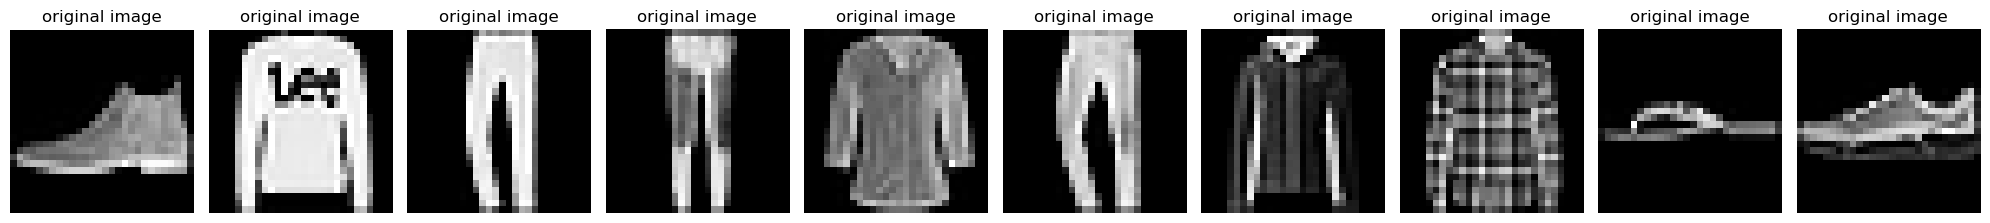

In [8]:
# 绘制基本图像
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
ax = ax.flatten()
for i in range(10):
    img = x_test[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title("original image")
plt.tight_layout()

接下来，我们定义自编码器模型 `AutoEncoderFashionMnist`，它的属性中包含编码器和解码器，这里编码器和解码器都是最简单的 MLP，编码器负责将 $28\times 28$ 的原始图像压缩到一个低维表示（用参数 `latent_size` 控制）

In [11]:
class AutoEncoderFashionMnist(tf.keras.Model):
    def __init__(self, latent_size : int=32):
        super(AutoEncoderFashionMnist, self).__init__()
        self.latent_size = latent_size
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_size, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(784, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28))
        ])
    
    def call(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        decoded = self.decoder(encoded, **kwargs)
        return decoded

    # 给定输入，返回编码后的结果
    def encode(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        return encoded

接下来，实例化模型，通过 `compile()` 方法设置优化器和损失函数，优化器使用 Adam，损失函数使用均方误差，调用 `fit()` 方法进行训练

In [21]:
autoencoder = AutoEncoderFashionMnist(latent_size=32)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError())

In [22]:
# 训练模型，注意输入 x 和输出 y 都是 x_train
autoencoder.fit(
    x=x_train, y=x_train, 
    epochs=10, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0293 - val_loss: 0.0176
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.013

接下来，我们对比自编码器重构图像的效果

In [23]:
n_sample = 10
encoded_image = autoencoder.encoder(x_test[:n_sample]).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

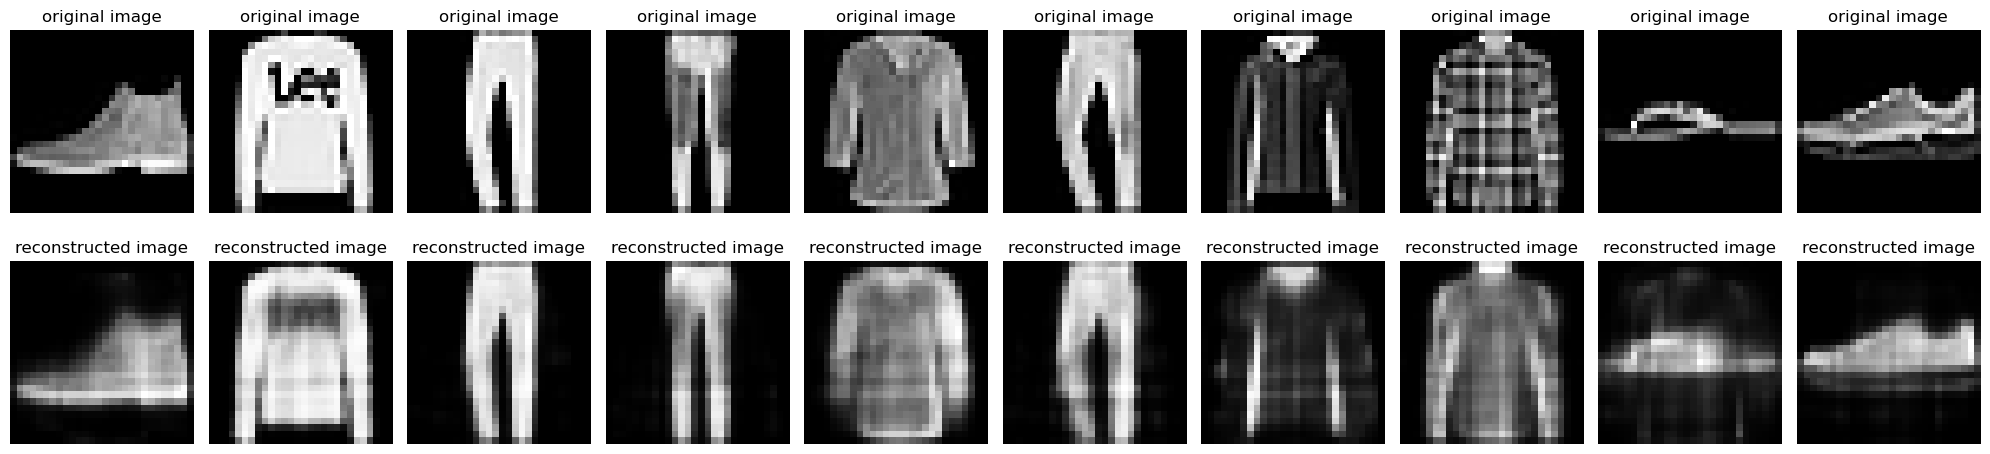

In [24]:
fig, ax = plt.subplots(2, n_sample, figsize=(2*n_sample, 5))
for i in range(n_sample):
    ax[0][i].imshow(x_test[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title("original image")
    ax[1][i].imshow(decoded_image[i], cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title("reconstructed image")
plt.tight_layout()

从恢复的图像可以观察到，这个简单的**自编码器恢复图像的大致内容是正确的，但图像关于衣服的细节（例如图案，文字）是缺失的**，这正是我们所需要的，我们需要自编码器捕获图像中的关键信息

接下来，我么尝试将自编码器的编码隐藏表示 $\mathbf{h}$ 用作 `FashionMNIST` 的分类任务

In [32]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

我们获得训练集和测试集的自编码器编码结果，然后进行训练

In [33]:
h_train, h_test = autoencoder.encode(x_train).numpy(), autoencoder.encode(x_test).numpy()
classifier.fit(
    x=h_train, y=y_train,
    epochs=20, batch_size=32, shuffle=True, validation_data=[h_test, y_test])

Epoch 1/20
1875/1875 [==============================] - 2s 688us/step - loss: 0.8579 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.5285 - val_sparse_categorical_accuracy: 0.8092
Epoch 2/20
1875/1875 [==============================] - 1s 553us/step - loss: 0.5283 - sparse_categorical_accuracy: 0.8077 - val_loss: 0.4823 - val_sparse_categorical_accuracy: 0.8240
Epoch 3/20
1875/1875 [==============================] - 1s 561us/step - loss: 0.4862 - sparse_categorical_accuracy: 0.8223 - val_loss: 0.4614 - val_sparse_categorical_accuracy: 0.8302
Epoch 4/20
1875/1875 [==============================] - 1s 568us/step - loss: 0.4661 - sparse_categorical_accuracy: 0.8302 - val_loss: 0.4567 - val_sparse_categorical_accuracy: 0.8336
Epoch 5/20
1875/1875 [==============================] - 1s 546us/step - loss: 0.4530 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.4386 - val_sparse_categorical_accuracy: 0.8375
Epoch 6/20
1875/1875 [==============================] - 1s 573us/step - loss: 0.

可以看到**使用自编码器压缩后的特征，分类器依然能够取得可观准确率**，这相比使用原始的图像特征作为分类器的输入，性能并没有衰减，在有些场合，自编码器加工得到的特征 $\mathbf{h}$ 去除了高维原始输入中的噪声和无效信号，甚至能提升分类器的性能

----

**(2) 去噪自编码器**

接下来，我们在 `FashionMNIST` 的图像中添加噪声，然后训练一个去燥自编码器，在这个实例中，我们将编码器和解码器替换为卷积神经网络

In [3]:
def add_normal_noise(x, std : float=0.2):
    """
    向图像中添加高斯噪声

    Parameters
    ----------
    std : float, default = 0.2
        控制噪声大小
    """
    x_noisy = x + std * tf.random.normal(shape=x.shape)
    # 确保像素值在 [0,1] 范围内
    x_noisy = tf.clip_by_value(x_noisy, clip_value_min=0.0, clip_value_max=1.0)

    return x_noisy

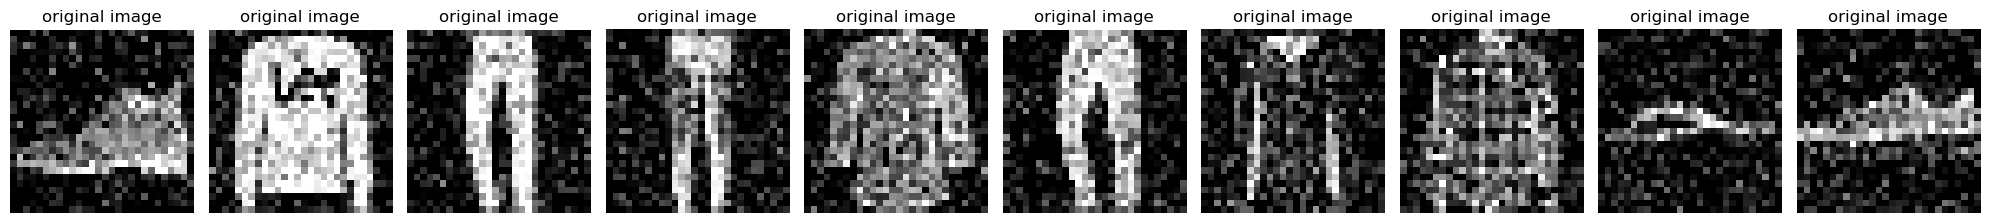

In [4]:
# 绘制加入噪声的样本
batch = x_test[0:10]
batch = add_normal_noise(x=batch)
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(batch[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title("original image")
plt.tight_layout()

结下来，定义我们的去噪自编码器 `DenoiseAutoEncoderFashionMnist`
* 编码器 $f$ 用一个简单的 CNN，最后通过 `Flatten()` 展平为向量
* 解码器 $g$ 用转置卷积，不断将隐藏特征扩展到原始图像大小

In [5]:
class DenoiseAutoEncoderFashionMnist(tf.keras.Model):
    def __init__(self, latent_size : int=32):
        super(DenoiseAutoEncoderFashionMnist, self).__init__()
        self.latent_size = latent_size
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, padding="same", activation='relu'),
            tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding="same", activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_size, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_size,)),
            tf.keras.layers.Dense(7*7*16),
            tf.keras.layers.Reshape((7, 7, 16)),
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation='sigmoid')
        ])
    
    def call(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        decoded = self.decoder(encoded, **kwargs)
        return decoded

    # 给定输入，返回编码后的结果
    def encode(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        return encoded

接下来，我们创建添加了噪声的训练数据集，同时为图像增加一个通道维度

In [6]:
x_train_noisy = add_normal_noise(tf.expand_dims(x_train, axis=-1)).numpy()
x_test_noisy = add_normal_noise(tf.expand_dims(x_test, axis=-1)).numpy()

测试一下不经过训练的去噪自编码器模型的重构效果

In [7]:
n_sample = 10
autoencoder = DenoiseAutoEncoderFashionMnist(latent_size=32)
encoded_image = autoencoder.encoder(x_test_noisy[:n_sample]).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

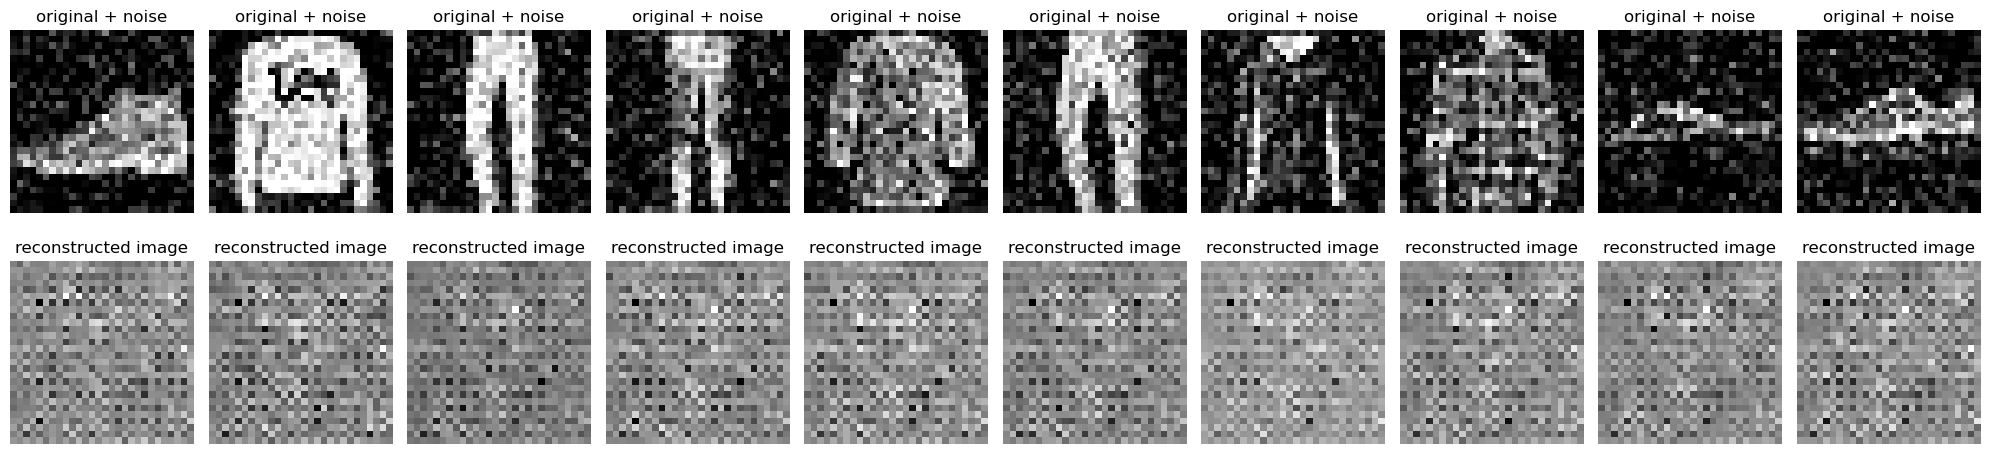

In [8]:
fig, ax = plt.subplots(2, n_sample, figsize=(2*n_sample, 5))
for i in range(n_sample):
    ax[0][i].imshow(x_test_noisy[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title("original + noise")
    ax[1][i].imshow(decoded_image[i], cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title("reconstructed image")
plt.tight_layout()

接下来，我们编译模型，进行训练
* 训练时，输入特征的包含噪声的样本 `x_train_noisy`，标签是不包含噪声的样本 `x_train`

In [9]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError())

In [10]:
autoencoder.fit(
    x=x_train_noisy, y=x_train, 
    epochs=10, batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0343 - val_loss: 0.0189
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0152 - val_loss: 0.0147
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 8/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 9/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 10/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0127 - val_loss: 0.0127

下面，再来观察一下 DAE 的去噪效果，可以观察到**经过编码后再解码的输出，很好地还原了原始图像的信息，而把无关的噪声过滤了**

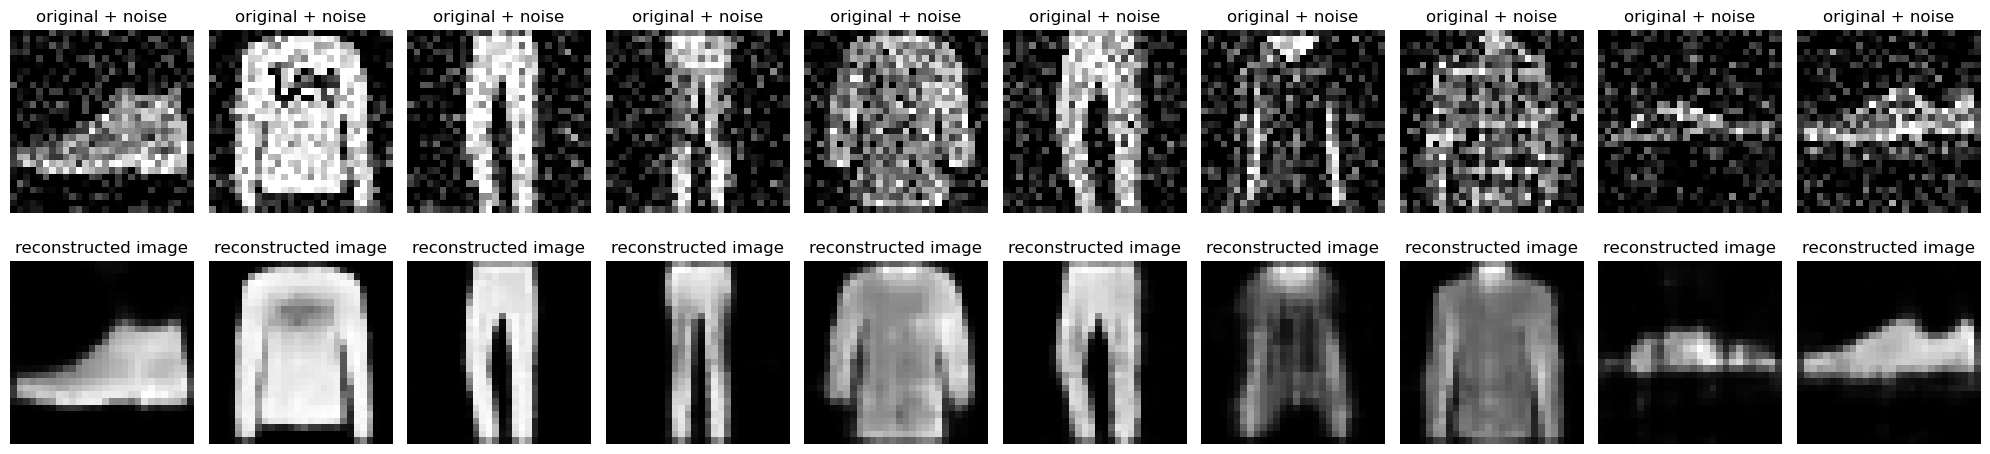

In [11]:
encoded_image = autoencoder.encoder(x_test_noisy[:n_sample]).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()
fig, ax = plt.subplots(2, n_sample, figsize=(2*n_sample, 5))
for i in range(n_sample):
    ax[0][i].imshow(x_test_noisy[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title("original + noise")
    ax[1][i].imshow(decoded_image[i], cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title("reconstructed image")
plt.tight_layout()

----

**(3) 自编码器做异常检测**

自编码器还可以用于异常检测，整体思路如下：
* 我们假设自编码器在**正常样本**上良好训练，那么对于给定的正常样本 $\mathbf{x}$，自编码器应该有良好的重构误差 $\varepsilon$
* 对于**正常分布之外的异常样本** $\tilde{\mathbf{x}}$，因为这类样本未出现在自编码器的训练数据集中，因此 $\tilde{\mathbf{x}}$ 的重构误差 $\tilde{\varepsilon}$ 会偏大
* 当我们**发现重构误差 $\tilde{\varepsilon}$ 超过自编码器误差 $\varepsilon$ 分布的正常范围时，就可以将其标识为异常样本**

我们以 `ECG5000` 心电图数据集为例，展示自编码器完成异常检测的过程，数据集中包含 5000 哥心电图样本，每个样本有 140 个时间步的心电采样点，构成心电图序列，**正常样本被标记为 0，异常样本被标记为 1（对应异常心律）**
* 注意，这是一个有标签的数据集，因此可以采用通常的有监督训练方式构建分类模型，完成异常检测
* 这里展示的是一种不需要标签信息的自监督异常检测方法，这在无可用标签，或可用标签较少时非常有效（尤其在医学领域，可以收集成千上万个健康人群的正常身体数据，但异常样本的收集就变的稀少和困难）

In [3]:
data = pd.read_csv("../source/data/tabular/ECG5000.csv")
label = data.pop('label')
print("number of samples: ", len(data))
print("number of the normal samples: ", sum(label==0))
print("number of the abnormal samples: ", sum(label==1))
data.head()

number of samples:  4998
number of the normal samples:  2919
number of the abnormal samples:  2079


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


为了便于神经网络处理，我们**将每个样本的时间序列**规范化到 $[0,1]$ 范围内

In [4]:
# 注意，标准化对每一行进行
min_val, max_val = data.min(axis=1), data.max(axis=1)
data = ((data.T - min_val) / (max_val - min_val)).T

我们来绘制正常心律和异常心律做一个对比

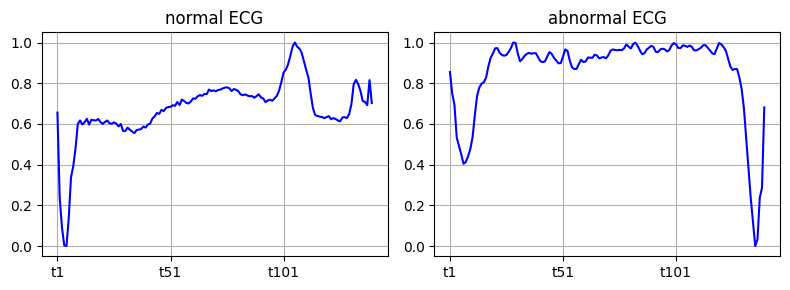

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
data.loc[(label == 0)].iloc[0].plot(ax=ax[0], color='blue')
ax[0].set_title("normal ECG")
ax[0].grid()
data.loc[(label == 1)].iloc[0].plot(ax=ax[1], color='blue')
ax[1].set_title("abnormal ECG")
ax[1].grid()
plt.tight_layout()

接下来，我们将数据集切分为训练集和验证集两部分，**再分别将样本区分为正常心律样本和异常心律样本**

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
x_train_normal, x_train_abnormal = x_train[y_train==0], x_train[y_train==1]
# x_test_normal, x_test_abnormal = x_test[y_test==0], x_test[y_test==1]

接下来，我们构建用于时间序列异常检测的自编码器模型 `TimeSeriesAutoEncoder`：
* 在编码器部分，我们**使用一个双向 LSTM 层来抽取特征**，最后用一个全连接层将最后一个时间步的输出形状变换到 `latent_size`
* 解码器使用一个简单的 MLP 变换到 `seq_len`，同时输出层使用 sigmoid 激活函数确保数值范围在 $[0,1]$ 之间

In [8]:
class TimeSeriesAutoEncoder(tf.keras.Model):
    def __init__(self, latent_size : int=32, seq_len : int=140) -> None:
        super(TimeSeriesAutoEncoder, self).__init__()
        self.latent_size = latent_size
        self.seq_len = seq_len
        # 编码器使用一个双向 LSTM 层
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(seq_len,)),
            tf.keras.layers.Reshape((seq_len, 1)), # RNN 层的输入必须是 3D 张量
            tf.keras.layers.LSTM(32, go_backwards=True),
            tf.keras.layers.Dense(latent_size, activation='relu')
        ])
        # 解码器使用 MLP
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_size,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(seq_len, activation='sigmoid'),
        ])

    def call(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        decoded = self.decoder(encoded, **kwargs)
        return decoded
    
    def encode(self, x, **kwargs):
        encoded = self.encoder(x, **kwargs)
        return encoded

接下来，我们创建模型，设置 `latent_size = 16`，然后**在正常心律的训练数据集 `x_train_normal` 上训练，在全部测试样本 `x_test` 上评估**

In [10]:
autoencoder = TimeSeriesAutoEncoder(latent_size=16, seq_len=140)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError())

In [11]:
history = autoencoder.fit(
    x=x_train_normal, y=x_train_normal,
    epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10


2023-12-21 10:52:25.488982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


19/19 [==============================] - 3s 43ms/step - loss: 0.0556 - val_loss: 0.0714
Epoch 2/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0355 - val_loss: 0.0403
Epoch 3/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0166 - val_loss: 0.0297
Epoch 4/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0097 - val_loss: 0.0284
Epoch 5/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0285
Epoch 6/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0078 - val_loss: 0.0284
Epoch 7/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 0.0283
Epoch 8/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 0.0287
Epoch 9/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.0285
Epoch 10/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.0284


绘制训练过程中训练集和测试集合上的损失函数变化，可以**观察到在模型收敛后，测试集上的损失明显偏大，这是因为测试样本中包含了很多异常心律样本**

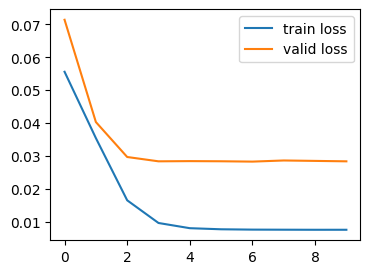

In [12]:
# 绘制训练过程中的 loss 曲线
fig = plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()

我们来绘制一下自编码器对序列的重构效果，可以观察到**模型对异常心律样本的重构误差显著增大**

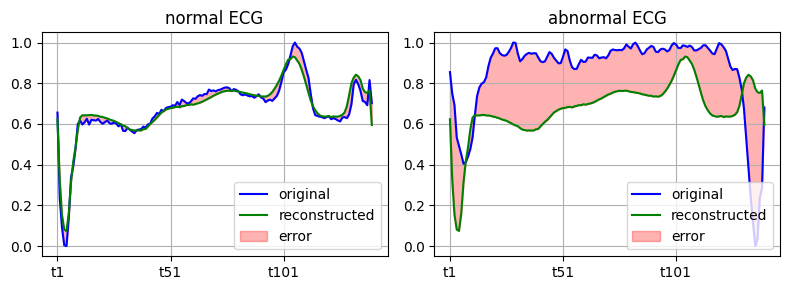

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# 绘制正常样本的重构结果
for l in [0, 1]:
    series = data.loc[(label == l)].iloc[0]
    series.plot(ax=ax[l],label='original',color='blue')
    reconstructed = autoencoder(series.values[None, ...]).numpy()
    ax[l].plot(reconstructed[0], label='reconstructed', color='green')
    ax[l].fill_between(x=range(140), y1=reconstructed.flatten(), y2=series.values, 
                       color='red', alpha=0.3, label='error')
    ax[l].grid()
    ax[l].legend(loc="lower right")
    ax[l].set_title("normal ECG" if l == 0 else "abnormal ECG")
plt.tight_layout()

接下来，我们绘制自编码器模型在训练集上正常心律样本和异常心律样本的重构误差分布
* 可以观察到，在训练数据集上，模型在异常心律样本上的重构误差均值大很多
* 我们可以基于此设定一个异常检测规则，选择阈值 $\tau = \mu + \sigma$，其中 **$\mu$ 是训练集正常样本的重构误差均值，$\sigma$ 是训练集正常样本的重构误差的标准差**，当样本重构误差大于 $\tau$ 时就标定为异常

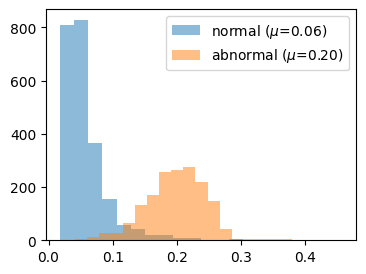

In [14]:
train_err_normal = tf.keras.losses.mae(x_train_normal.values, autoencoder(x_train_normal))
train_err_abnormal = tf.keras.losses.mae(x_train_abnormal.values, autoencoder(x_train_abnormal))
fig = plt.figure(figsize=(4, 3))
plt.hist(train_err_normal.numpy(), bins=20, alpha=0.5, label='normal ($\mu$={:.2f})'.format(train_err_normal.numpy().mean()))
plt.hist(train_err_abnormal.numpy(), bins=20, alpha=0.5, label='abnormal ($\mu$={:.2f})'.format(train_err_abnormal.numpy().mean()))
plt.legend()

In [15]:
def abnormal_detect_logic(err, threshold : float=0.1):
    return tf.cast(err > threshold, tf.int32)

threshold = train_err_normal.numpy().mean() + train_err_normal.numpy().std()
print("重构误差检测异常阈值：", threshold)

重构误差检测异常阈值： 0.09615129


最后，我们在测试集上做出预测，并评估模型的性能
* 可以观察到，模型的**召回率很高，精确率稍低，说明该异常检测规则容易将一些正常样本标记为异常样本**

In [17]:
# 做出预测，计算 AUC
test_pred = abnormal_detect_logic(
    tf.keras.losses.mae(x_test.values, autoencoder(x_test)), threshold=threshold)
print("AUC on test set: %.3f" % roc_auc_score(y_true=y_test, y_score=test_pred))
print("Recall on test set: %.3f" % recall_score(y_true=y_test, y_pred=test_pred))
print("Precision on test set: %.3f" % precision_score(y_true=y_test, y_pred=test_pred))

AUC on test set: 0.940
Recall on test set: 0.976
Precision on test set: 0.877


----

## **9.4.2 变分自编码**

**变分自编码器（Variational Auto-Encoder，VAE）**是另一种类型的自编码模型，与前面讨论的自编码器模型不同，VAE 对样本的生成过程建模，并将样本 $\mathbf{x}$ **压缩到一个隐藏的概率分布**，而不仅是一个隐藏向量 $\mathbf{z}$，未了介绍 VAE，我们需要先介绍**变分推断（Variational Inference）**的相关内容

### **9.4.2.1 变分推断**

我们回顾到概率建模问题，在**生成过程概率模型**的视角下，样本 $\mathbf{x}$ 由某个**隐藏的、不可观测的隐向量** $\mathbf{z}$ 决定，实践中，人们关心**后验分布** $p(\mathbf{z} | \mathbf{x})$，即给定收集到的观测样本 $\mathbf{x}$ 时，产生该样本的隐向量 $\mathbf{z}$ 的分布是什么
* 例如在图像生成方面，不同的苹果图片 $\mathbf{x}$ 可能都是由**隐藏语义为苹果的隐向量** $\mathbf{z}$ 生成
* 又例如对于一个简单的高斯混合模型：
    $$
    x = c_1\cdot z_1 + c_2\cdot z_2,\quad z_k\sim N(\mu_k,\sigma_k^2),\quad k=1,2
    $$

    当我们收集到大量混合分布的样本 $\{x_i\}$ 后，就可以尝试估计这个复杂模型的隐藏参数 $c_k$，以及隐向量 $(z_1,z_2)$ 的分布

通常，后验概率的计算可以使用贝叶斯公式：
$$
\displaystyle{
p(\mathbf{z} | \mathbf{x}) = \frac{p(\mathbf{x}, \mathbf{z})}{p(\mathbf{x})} =
\frac{p(\mathbf{x}, \mathbf{z})}{
    \displaystyle{\int_\mathbf{z} p(\mathbf{x} | \mathbf{z}) d\mathbf{z}}}
}
$$

但上述计算过程中，边际密度的计算需要全概率公式计算：
$$
\int_\mathbf{z} p(\mathbf{x} | \mathbf{z}) d\mathbf{z}
$$

在实际应用时，**$\mathbf{z}$ 通常是一个高维随机向量，这使得上述积分的计算将变得非常困难**，因此用贝叶斯公式来获得后验分布在计算上行不通

变分推断（Variational Inference）提出了一种估计后验分布 $p(\mathbf{z} | \mathbf{x})$ 的替代方案，其核心思想包括两步：
1. 假设一个**参数化的分布 $q(\mathbf{z} | \mathbf{x}; \phi)$，其中 $\phi$ 是分布参数**，这个分布的构成简单，便于我们计算
2. 通过改进分布的参数 $\phi$，**使得 $q(\mathbf{z} | \mathbf{x}; \phi)$ 靠近后验 $p(\mathbf{z} | \mathbf{x})$**

简单来说，**变分推断为后验分布引入一个参数化的模型，用一个简单的分布 $q(\mathbf{z} | \mathbf{x}; \phi)$ 去拟合复杂分布 $p(\mathbf{z} | \mathbf{x})$**，当优化完成后，$q(\mathbf{z} | \mathbf{x}; \phi)$ 就成为了后验分布 $p(\mathbf{z} | \mathbf{x})$ 的一个替代，如果用 KL 散度来度量这两个分布之间的距离，那么变分推断的优化目标为：
$$
\phi^* = \mathop{\arg\min}\limits_{\phi} \text{KL}\left(
    q(\mathbf{z} | \mathbf{x};\phi) || p(\mathbf{z} | \mathbf{x})
\right)
$$

下面我们考虑模型求解的问题，注意到：
$$
p(\mathbf{x}) = \frac{p(\mathbf{x}, \mathbf{z})}{p(\mathbf{z} | \mathbf{x})}
$$

两边取对数，然后使用变分法的核心，将概率 $q(\mathbf{z} | \mathbf{x}; \phi)$ 引入，得到：
$$
\newcommand{\arraystretch}{2}
\begin{array}{rcl}
\log{ p(\mathbf{x})} & = & \log{ p(\mathbf{x}, \mathbf{z}) } - \log{ p(\mathbf{z} | \mathbf{x}) } \\
& = & \displaystyle{
    \log{\frac{ p(\mathbf{x}, \mathbf{z}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }} - \log{\frac{ p(\mathbf{z} | \mathbf{x}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }}
}
\end{array}
$$

在上式两侧，对分布 $q(\mathbf{z} | \mathbf{x}; \phi)$ 求数学期望，得到：
$$
\renewcommand{\arraystretch}{2}
\begin{array}{rcl}
\log{ p(\mathbf{x})} & = & \displaystyle{
    \mathbb{E}_{ q(\mathbf{z} | \mathbf{x}; \phi) } \log{\frac{ p(\mathbf{x}, \mathbf{z}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }} - \mathbb{E}_{ q(\mathbf{z} | \mathbf{x}; \phi) } \log{\frac{ p(\mathbf{z} | \mathbf{x}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }}
} \\
& = & \displaystyle{
    \text{KL}\left( q(\mathbf{z} | \mathbf{x};\phi) || p(\mathbf{z} | \mathbf{x}) \right) + 
    \mathbb{E}_{ q(\mathbf{z} | \mathbf{x}; \phi) } \log{\frac{ p(\mathbf{x}, \mathbf{z}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }}
} \\
\end{array}
$$

至此，回顾我们的目标通过优化参数 $\phi$ 使分布 $p(\mathbf{z} | \mathbf{x})$ 和 $q(\mathbf{z} | \mathbf{x};\phi)$ 靠近，即：
$$
\mathop{\min}\limits_{\phi} \text{KL}\left(
    q(\mathbf{z} | \mathbf{x};\phi) || p(\mathbf{z} | \mathbf{x})
\right)
$$

但是这个散度中包含我们难以处理的后验 $p(\mathbf{z} | \mathbf{x})$，再注意到上面计算得到的等式：
$$
\log{ p(\mathbf{x})} = \text{KL}\left( q(\mathbf{z} | \mathbf{x};\phi) || p(\mathbf{z} | \mathbf{x}) \right) + 
    \mathbb{E}_{ q(\mathbf{z} | \mathbf{x}; \phi) } \log{\frac{ p(\mathbf{x}, \mathbf{z}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }}
$$

**将 $\phi$ 看作等式的变量，此时等式左边 $\log{ p(\mathbf{x})}$ 是一个常量**，那么极小化 KL 散度，就**等价于极大化右侧第二项**：
$$
\mathop{\max}\limits_{\phi} \mathbb{E}_{ q(\mathbf{z} | \mathbf{x}; \phi) } \log{\frac{ p(\mathbf{x}, \mathbf{z}) }{ q(\mathbf{z} | \mathbf{x}; \phi) }}
$$

因此，变分推断的优化目标变为：
$$
\mathop{\arg\max}\limits_{\phi} \mathbb{E}_{ q(\mathbf{z} | \mathbf{x};\phi) } \left[
    \log{ p(\mathbf{x}, \mathbf{z})} - \log{ q(\mathbf{z} | \mathbf{x};\phi) }
\right]
$$

其中，$\mathcal{L}(\phi;\mathbf{x}) = \mathbb{E}_{ q(\mathbf{z} | \mathbf{x};\phi) } \left[ \log{ p(\mathbf{x}, \mathbf{z})} - \log{ q(\mathbf{z} | \mathbf{x};\phi) } \right]$ 被称为**证据下界（Evidence Lower Bound，ELBO）**，变分推断的优化目标即**最大化 ELBO**，因为 $\log p(\mathbf{x})$ 一般被称为 evidence，又因为 KL 散度 $\text{KL}(q || p)\geq 0$，因此：
$$
\log p(\mathbf{x}) \geq \mathbb{E}_{ q(\mathbf{z} | \mathbf{x};\phi) } \left[ \log{ p(\mathbf{x}, \mathbf{z})} - \log{ q(\mathbf{z} | \mathbf{x};\phi) } \right]
$$

这就是证据下界 ELBO 名字的由来

在统计中，人们通常利用**平均场变分族**（**mean-field variational family**）来求解变分推断问题，$q(\mathbf{z} | \mathbf{x};\phi)$ 是人们假设的分布，$q$ 的选择直接决定了变分问题的难度，一个简单有效的选择是**平均场变分族**，即**假设隐藏向量** $\mathbf{z}$ 是**相互独立**的：
$$
q(\mathbf{z} | \mathbf{x};\phi) = \prod_{k=1}^{K} q_k(z_k|\mathbf{x};\phi_k)
$$

相互独立的假设看起来很强，但在实际应用中非常广泛和有效，现在利用 ELBO 和平均场变分族假设，就可以用**坐标下降法**来求解模型参数了，出于记号简单考虑，接下来我们将 $q(\mathbf{z}|\mathbf{x};\phi)$ 简单记为 $q(\mathbf{z})$，具体地：
$$
\text{ELBO} = \int_{\mathbf{z}} q(\mathbf{z})\cdot \log p(\mathbf{x},\mathbf{z}) d\mathbf{z} - \int_{\mathbf{z}} q(\mathbf{z})\log q(\mathbf{z}) d\mathbf{z}
$$

对于某个分量 $q_j$，我们有：
$$
\renewcommand{\arraystretch}{2}
\begin{array}{rcl}
\displaystyle{ \int_{\mathbf{z}} q(\mathbf{z})\log p(\mathbf{x},\mathbf{z}) d\mathbf{z} } & = & 
\displaystyle{ \int_\mathbf{z} \prod_{k=1}^{K} q_k(z_k) \log p(\mathbf{x},\mathbf{z}) d z_1\cdots d z_K } \\
& = & \displaystyle{ \int_z q_j(z_j)\left( \int_\mathbf{z} \prod_{k=1,k\ne j}^{K} q_k(z_k) \log p(\mathbf{x},\mathbf{z}) \mathop{d z_1\cdots d z_K}\limits_{k\ne j} \right) d z_j } \\
& = & \displaystyle{ \int_z q_j(z_j)\cdot \mathbb{E}_{q_{-j}} [\log p(\mathbf{x},\mathbf{z})] d z_j }
\end{array}
$$

其中，**$\mathbb{E}_{q_{-j}} [\log p(\mathbf{x},\mathbf{z})]$ 表示去掉分布 $q(\mathbf{z})$ 第 $j$ 个分量后的数学期望**：
$$
\mathbb{E}_{q_{-j}} [\log p(\mathbf{x},\mathbf{z})] = \int_\mathbf{z} \prod_{k=1,k\ne j}^{K} q_k(z_k) \log p(\mathbf{x},\mathbf{z}) \mathop{d z_1\cdots d z_K}\limits_{k\ne j}
$$

对于第二项，同样关注分量 $q_j$，将其他部分当作常数，我们有：
$$
\renewcommand{\arraystretch}{2}
\begin{array}{rcl}
\displaystyle{ \int_{\mathbf{z}} q(\mathbf{z})\log q(\mathbf{z}) d\mathbf{z} } & = & 
\displaystyle{ \int_{\mathbf{z}} \prod_{k=1}^{K} q_k(z_k) \cdot \log \prod_{k=1}^{K} q_k(z_k) d\mathbf{z} } \\
& = & \displaystyle{ \int_{\mathbf{z}} \prod_{k=1}^{K} q_k(z_k) \cdot \sum_{k=1}^{K}\log q_k(z_k) d\mathbf{z} } \\
& = & \displaystyle{ \int_\mathbf{z} \sum_{k=1}^{K} \log q_k(z_k)\cdot \prod_{i=1}^{K} q_i(z_i) d\mathbf{z} } \\
& = & \displaystyle{ \sum_{k=1}^{K} \int_\mathbf{z}\log q_k(z_k) \cdot \prod_{i=1}^{K} q_i(z_i) d\mathbf{z} } \\
& = & \displaystyle{ \int_z \log q_j(z_j)\cdot q_j(z_j) d z_j  + C}
\end{array}
$$

因此，在优化 ELBO 时，针对分量 $q_j$，我们有：
$$
\text{ELBO}(q_j) = \int_z q_j(z_j)\left(\mathbb{E}_{q_{-j}} [\log p(\mathbf{x},\mathbf{z})] - \log q_j(z_j)  \right) dz + C
$$

得到坐标下降法的更新法则为：
$$
q_j^*(z_j) \propto \exp{ \mathbb{E}_{q_{-j}} [\log p(\mathbf{x},\mathbf{z})] }
$$

### **9.4.2.2 自编码变分贝叶斯**

在介绍了变分推断的相关背景后，下面我们来形式化 VAE 需要解决的问题，假设我们有独立同分布的数据集 $\mathbf{X} = \{\mathbf{x}^{(i)}\}$，每个样本 $\mathbf{x}$ 可以是连续的或者离散的，我们**假设这些数据通过某个随机过程生成得到**，该过程包含一个**无法观测的连续随机变量 $\mathbf{z}^{(i)}$**，可以分为下面两步：
* (1) 隐变量 $\mathbf{z}^{(i)}$ 从一个先验分布 $p_{\theta^*}(\mathbf{z})$ 抽样得到
* (2) 样本 $\mathbf{x}^{(i)}$ 从条件分布 $p_{\theta^*}(\mathbf{x} | \mathbf{z})$ 抽样得到

我们假设先验 $p_{\theta^*}(\mathbf{z})$ 和似然 $p_{\theta^*}(\mathbf{x} | \mathbf{z})$ 来自于参数分布族 $p_{\theta}(\mathbf{z})$ 和 $p_{\theta}(\mathbf{x} | \mathbf{z})$，并且它们的累积分布函数几乎处处可微，在这个过程中，**真实分布参数 $\theta^*$ 和隐变量 $\mathbf{z}^{(i)}$ 对于我们而言都是未知的，不可观测的**，需要注意，在下面的讨论中，我们**不会像平均场变分族一样对边际分布或后验分布做出任何简化假设**，我们希望得到一般通用、在以下场景均能高效进行的算法：
* 边际分布的积分 $p_\theta(\mathbf{x}) = \int p_\theta (\mathbf{z})p_\theta(\mathbf{x}|\mathbf{z}) d\mathbf{z}$ 难以处理，真实的后验密度 $p_\theta(\mathbf{z} | \mathbf{x}) = p_\theta(\mathbf{x}|\mathbf{z})\cdot p_\theta(\mathbf{z}) / p_\theta(\mathbf{x})$ 难以处理（在这种场景下，EM 算法无法使用），以及任意平均场变分族中所需要计算的积分难以处理等情形，这些问题在实际应用中非常常见
* 我们拥有大量的数据集（百万数量级以上），以至于批量优化的方法都需要高昂的计算代价，我们需要利用很小的 mini-batch 策略甚至单样本策略来更新模型参数，因此，基于采样的方法，例如 Monte Carlo EM，在这种场景下会非常缓慢以至于不可行

VAE 希望达成的目标有以下三个：
* 高效地得到参数 $\theta$ 的极大似然估计：如果我们想要分析自然过程，对参数 $\theta$ 的挖掘可以帮助我们理解隐藏数据背后的随机过程，并生成与真实数据分布相同的人工数据
* 对于选定的参数 $\theta$，给定观测样本 $\mathbf{x}$，高效地获得隐变量 $\mathbf{z}$ 的后验估计：这可以帮助我们实现对样本的隐藏表示编码
* 高效地进行样本 $\mathbf{x}$ 边际推断：这可以帮助我们很多依赖 $\mathbf{x}$ 先验的推断任务，例如 CV 中的图像去噪、图像超采样

与变分推断类似，我们**引入一个辨识模型 $q_\phi(\mathbf{z} | \mathbf{x})$ 以近似难以处理的真实后验 $p\theta(\mathbf{z} | \mathbf{x})$**，注意与变分推断中介绍的平均场变分族不同，我们不需要 $q_\phi(\mathbf{z} | \mathbf{x})$ 需要有独立性假设，模型的参数 $\phi$ 也不需要有闭式解，下面，我们会介绍一种，**联合学习参数 $\theta$ 和辨识模型参数 $\phi$** 的方法

从编码器的角度出发，无法观测的隐变量 $\mathbf{z}$ 可以解释为观测样本 $\mathbf{x}$ 的隐藏表示或编码结果，因此，**辨识模型 $q_\phi(\mathbf{z}|\mathbf{x})$ 将会被视为一个概率编码器**，每当给定一个样本 $\mathbf{x}$，$q$ 可以生成一个用于产生样本 $\mathbf{x}$ 的编码 $\mathbf{z}$ 可能取值上的分布（例如高斯分布），与此类似，我们**将 $p_\theta(\mathbf{x} | \mathbf{z})$ 视为一个概率解码器**，每当给定一个编码 $\mathbf{z}$，它可以生成一个对应生成样本 $\mathbf{x}$ 的可能取值上的分布

**(1) 变分下界 ELBO**

下面，我们回到变分推断的部分，回忆 $\log p_\theta(\mathbf{x}^{(i)})$ 有：
$$
\log p_\theta(\mathbf{x}^{(i)}) = \text{KL}\left(
    q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z} | \mathbf{x}^{(i)})
\right) + \mathcal{L}(\theta,\phi;\mathbf{x}^{(i)})
$$

第二项 $\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)})$ 即为 ELBO，利用贝叶斯公式，可以整理得到：
$$
\begin{array}{rcl}
\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)}) & = & \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} 
\left[ \log p_\theta(\mathbf{x}^{(i)}, \mathbf{z}) - \log q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) \right] \\
& = & \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} 
\left[ \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}) + \log p_\theta(\mathbf{z}) - \log q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) \right] \\
& = & -\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})}  \left[ \log q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) - \log p_\theta(\mathbf{z})  \right] + \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} \left[ \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}) \right] \\
& = & -\text{KL}\left( q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z}) \right) + \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} \left[ \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}) \right]
\end{array}
$$

我们希望让 ELBO $\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)})$ 对变分参数 $\phi$ 和生成模型参数 $\theta$ 求梯度进而优化 ELBO，但是，**$\phi$ 的梯度的计算会遇到困难，通常的方法是使用 Monte Carlo 梯度估计**，即：
$$
\nabla_\phi \mathbb{E}_{q_\phi(\mathbf{z})} [f(\mathbf{z})] = \mathbb{E}_{q_\phi(\mathbf{z})} \left[
    f(\mathbf{z})\nabla_{\phi} \log q_\phi(\mathbf{z}) 
\right] \approx \frac{1}{L}\sum_{l=1}^{L} f(\mathbf{z}) \nabla_{\phi} \log q_\phi(\mathbf{z}^{(l)})
$$

其中 $\mathbf{z}^{(l)}\sim q_\phi(\mathbf{z} | \mathbf{x}^{(i)})$，第一个等式用到了：
$$
\begin{array}{rcl}
\nabla_\phi \mathbb{E}_{q_\phi(\mathbf{z})} [f(\mathbf{z})] & = & 
\displaystyle{ \nabla_\phi \int_\mathbf{z} q_\phi(\mathbf{z}) f(\mathbf{z}) d\mathbf{z} } \\
& = & \displaystyle{ \int_\mathbf{z}  f(\mathbf{z})\nabla_\phi q_\phi(\mathbf{z}) d\mathbf{z} } \\
& = & \displaystyle{ \int_\mathbf{z}  q_\phi(\mathbf{z}) \cdot f(\mathbf{z})\nabla_\phi \log q_\phi(\mathbf{z}) d\mathbf{z} } \\
& = & \displaystyle{ \mathbb{E}_{q_\phi(\mathbf{z})} \left[ f(\mathbf{z}) \nabla_\phi \log q_\phi(\mathbf{z}) \right] }
\end{array}
$$

但是，**Monte Carlo 梯度估计方法存在很大的方差，同时需要付出昂贵的计算花销，并不能满足我们前面提到的设想**

**(2) 重参数化技巧**

下面，我们来讨论如何计算 ELBO $\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)})$ 及其梯度，在此之前，我们需要先介绍**重参数化技巧**
* 在梯度的计算过程中，我们需要从分布 $q_\phi(\mathbf{z} | \mathbf{x})$ 中采样 $\mathbf{z}$，一般的采样会导致**梯度流丢失**，我们希望随机样本 $\mathbf{z}^{(l)} \sim q_\phi(\mathbf{z} | \mathbf{x}) $ 携带 $\phi$ 的信息，从而**当使用自动微分时，这些梯度流可以随着随机样本进行传递**
* 因此，这里可以使用**重参数化技巧**，将随机样本 $\mathbf{z}$ 重新表达，通常情况下，**随机变量 $\mathbf{z}$ 可以用另一个辅助变量 $\mathbf{\epsilon}$ 表达为 $\mathbf{z} = g_\phi(\mathbf{\epsilon},\mathbf{x})$，辅助变量 $\mathbf{\epsilon}$ 具有独立的边际分布 $p(\mathbf{\epsilon})$**，而 $g_\phi$ 是以 $\phi$ 为参数的向量值函数，**通过重参数化技巧，采样的随机性由 $\mathbf{\epsilon}$ 保证，而随机样本 $\mathbf{z}$ 会通过映射 $g_\phi$ 携带着 $\phi$ 的梯度流**
* 在进行重参数化时，对于积分微元，我们有：
$$
q_\phi(\mathbf{z}|\mathbf{x}) \prod_{i}d z_i = p(\mathbf{\epsilon}) \prod_{i} d \epsilon_i
$$

因此，对于所需要考虑的期望 $\mathbb{E}_{q_\phi(\mathbf(z) | \mathbf{x})}[f(\mathbf{z})]$，有：
$$
\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})}[f(\mathbf{z})] = 
\int_\mathbf{z} q_\phi(\mathbf{z} | \mathbf{x}) f(\mathbf{z}) d\mathbf{z} = \int_{\mathbf{\epsilon}} p(\mathbf{\epsilon}) f(\mathbf{z}) d\mathbf{\epsilon} = \int_{\mathbf{\epsilon}} p(\mathbf{\epsilon}) f(g_\phi (\mathbf{\epsilon},\mathbf{x})) d\mathbf{\epsilon}
$$

经过重参数化后，我们得到了一个关于 $\phi$ 可微的期望估计器：
$$
\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})}[f(\mathbf{z})] \approx \frac{1}{L}\sum_{l=1}^{L} f(g_\phi(\mathbf{\epsilon}^{(l)}, \mathbf{x})),\quad \mathbf{\epsilon}\sim p(\mathbf{\epsilon})
$$

**将重参数化技巧应用到 ELBO，我们就可以得到一个关于参数 $\phi,\theta$ 可微的 ELBO 估计器**

我们下面来看一个重参数化的简单例子，假设 $z\sim p(z|x) = N(\mu,\sigma^2)$，此时，我们可以将 $z$ 重参数化为：
$$
z = \mu + \sigma\epsilon
$$

其中，$\epsilon$ 是辅助的随机噪声，采样自 $\epsilon\sim N(0,1)$，因此：
$$
\mathbb{E}_{N(z;\mu,\sigma^2)} [f(z)] = \mathbb{E}_{N(\epsilon;0,1)} [f(\mu + \sigma\epsilon)]
\approx \frac{1}{L} \sum_{l=1}^{L} f(\mu + \sigma\epsilon^{(l)}),\quad \epsilon\sim N(0,1)
$$

对一般的分布 $q_\phi$ 进行重参数化，大概可以分为以下三种情况：
* **CDF 的逆是可求解的**：在这种情况下取 $\epsilon\sim U[0,1]$，然后取 $g_\phi(\epsilon,\mathbf{x})$ 为 $q_\phi(\mathbf{z} | \mathbf{x})$ 的 CDF 的逆，常见的例子有：指数分布，Cauchy 分布，Logistic 分布，Rayleigh，Pareto，Weibull 等
* **类似于 Gauss 分布族**：对于任意由位置和形状参数确定的分布族，我们可以选择标准分布（位置参数 `loc = 1`，形状参数 `scale = 1`）作为辅助变量 $\epsilon$ 的分布 $p(\epsilon)$，然后取 $g_\phi = \text{loc} + \text{scale}\cdot \epsilon$，常见的例子有：Laplace 分布，Elliptical 分布，t 分布，均匀分布，Gauss 分布等
* **复合情形**：有的分布可能是上面两种情况的复合，我们可以按照层次将它们分解并依次选用合适的 $g$ 进行复合表达，常见的例子有：Log-Normal 对数正态分布，Gamma 分布，Dirichlet 分布，Beta 分布，卡方分布，F 分布

**(3) ELBO 的 SGVB 估计器和 AEVB 算法**

回忆 ELBO $\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)})$ 的定义为：
$$
\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)}) = \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} \left[
    \log p_\theta(\mathbf{x}^{(i)},\mathbf{z}) - \log q_\phi(\mathbf{z} | \mathbf{x}^{(i)})
\right]
$$

将重参数化技巧引入，设 $\mathbf{z} = g_\phi(\epsilon, \mathbf{x}),\epsilon\sim p(\epsilon)$，得到**随机梯度变分贝叶斯估计器**（**Stochastic Gradient Variational Bayes，SGVB**）$\mathcal{L}^{A}(\theta,\phi;\mathbf{x}^{(i)})$：
$$
\tilde{\mathcal{L}}^{A}(\theta,\phi;\mathbf{x}^{(i)}) = \frac{1}{L} \sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)}, \mathbf{z}^{(l,i)}) - \log q_\phi(\mathbf{z}^{(l,i)} | \mathbf{x}^{(i)})
$$

其中，$\mathbf{z}^{(l,i)} = g_\phi(\epsilon^{(l)}, \mathbf{x}^{(i)}), \epsilon^{(l)}\sim p(\epsilon)$

另一方面，ELBO 可以写作另一种表达形式是：
$$
\mathcal{L}(\theta,\phi;\mathbf{x}^{(i)}) = -\text{KL}\left( q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z}) \right) + \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} \left[ \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}) \right]
$$

而其中，KL 散度 $\text{KL}\left( q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z}) \right)$ 通常可以通过积分解析求解，这意味着我们**只需要对期望重构误差项 $\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x}^{(i)})} \left[ \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}) \right]$ 进行采样估计**，在这种表达形式下，**KL 散度一项可以理解为对 $\phi$ 的正则化项，它鼓励后验估计不断去逼近先验 $p_\theta(\mathbf{z})$**，因此我们得到第二种类型的 SGVB 估计器如下：
$$
\tilde{\mathcal{L}}^{B}(\theta,\phi;\mathbf{x}^{(i)}) = -\text{KL}\left( q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z}) \right) + \frac{1}{L}\sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}^{(l,i)})
$$

其中，$\mathbf{z}^{(l,i)} = g_\phi(\epsilon^{(l)}, \mathbf{x}^{(i)}), \epsilon^{(l)}\sim p(\epsilon)$，**通常情况下，$\tilde{\mathcal{L}}^{B}(\theta,\phi;\mathbf{x}^{(i)})$ 相比 $\tilde{\mathcal{L}}^{A}(\theta,\phi;\mathbf{x}^{(i)})$ 在估计时会有更小的方差**

现在，给定从数据集 $\mathbf{X} = \{\mathbf{x}^{(i)}\}_{i=1}^{N}$，从中抽取 $M$ 个样本，我们就可以构造整个数据集 ELBO 的估计结果了：
$$
\mathcal{L}(\theta,\phi;\mathbf{X}) \approx \tilde{\mathcal{L}}^{M}(\theta,\phi;\mathcal{X}^M) = \frac{N}{M}\sum_{i=1}^{M} \tilde{L}(\theta,\phi;\mathbf{x}^{(i)})
$$

其中，$\mathbf{X}^M = \{\mathbf{x}^{(i)}\}_{i=1}^{M}$ 表示从完整数据集中随机抽取的一个小批量，在实践中，只要 $M$ 充分大（例如 $M = 100$），在 $\tilde{\mathcal{L}}(\theta,\phi;\mathbf{x}^{(i)})$ 的计算中，我们可以将随机采样的大小 $L$ 设置为 $L=1$

现在，ELBO 的估计器关于参数 $\theta,\phi$ 的梯度 $\nabla_{\theta,\phi}\tilde{\mathcal{L}}(\theta,\phi,\mathbf{X}^M)$，并且可以通过自动微分配合任何其他优化算法来更新模型参数，具体可以见下面的**小批量自动编码变分贝叶斯算法**（**Auto-Encoding Variational Bayes，AEVB**）

<div style="border-top: 2px dashed red;"></div>

* **AEVB 算法**（小批量自动编码变分贝叶斯算法）
* 参数：训练迭代轮次 $N$，批量大小 $M = 100$，随机噪声采样次数 $L = 1$
* **`for n = 1 to N`**
    * 从 $\mathbf{X}$ 中随机采样 $M$ 个样本得到 $\mathbf{X}^M$
    * 从辅助噪声先验 $p(\epsilon)$ 中随机采样 $\epsilon$
    * 计算 $\tilde{\mathcal{L}}^M(\theta,\phi;\mathbf{X}^M,\epsilon)$，可以使用 $\tilde{\mathcal{L}}^A$ 或者 $\tilde{\mathcal{L}}^B$
    * 计算梯度 $\mathbf{g} = \nabla_{\theta,\phi} \tilde{\mathcal{L}}^M(\theta,\phi;\mathbf{X}^M,\epsilon)$，然后用梯度 $\mathbf{g}$ 更新参数 $\theta,\phi$
* **`end for`**

<div style="border-top: 2px dashed red;"></div>

### **9.4.2.3 变分自编码器**

接下来，我们可以将上面的变分贝叶斯推断技巧和自编码模型联系在一起，注意我们优化的目标函数 $\tilde{\mathcal{L}}^{B}(\theta,\phi;\mathbf{x}^{(i)})$：
$$
\tilde{\mathcal{L}}^{B}(\theta,\phi;\mathbf{x}^{(i)}) = -\text{KL}\left( q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z}) \right) + \frac{1}{L}\sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}^{(l,i)})
$$

其中，**第一项可以看做正则化项，而第二项是期望重构误差**
* 函数 $g_\phi$ 将样本 $\mathbf{x}^{(i)}$ 和一个随机噪声 $\epsilon^{(l)}$ 映射到一个来自于近似后验 $q_\phi(\mathbf{z} | \mathbf{x}^{(i)})$ 的隐变量样本 $\mathbf{z}^{(i,l)} = g_\phi(\epsilon^{(l)}, \mathbf{x}^{(i)})$
* $\mathbf{z}^{(i,l)}$ 作为函数 $\log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}^{(i,l)})$ 的输入，以计算给定隐变量 $\mathbf{z}^{(i,l)}$ 条件下重构出样本 $\mathbf{x}^{(i)}$ 的概率，这在自编码器模型的视角下可以作为重构误差项
* KL 散度一项鼓励近似后验 $q_\phi(\mathbf{z} | \mathbf{x}^{(i)})$ 不断靠近先验 $p_\theta(\mathbf{z})$

下面，我们来举一个具体的例子，我们将**使用神经网络来构造概率编码器 $q_\phi(\mathbf{z} | \mathbf{x})$（用于逼近生成模型 $p_\theta(\mathbf{x}, \mathbf{z})$ 的后验**），模型的参数 $\theta,\phi$ 使用 AEVB 算法一同更新

假设隐变量 $\mathbf{z}$ 的先验分布是中心化且标准化的对角多元高斯分布 $p_\theta(\mathbf{z}) = N(\mathbf{z};\mathbf{0},\mathbf{I})$，**注意在该假设下，先验是没有参数的**，对于概率解码器 $p(\mathbf{x} | \mathbf{z})$，我们假设：
* 如果 $\mathbf{x}$ 是连续变量，则 $p(\mathbf{x} | \mathbf{z})$ 是多元高斯分布
* 如果 $\mathbf{x}$ 是 0-1 二元变量，则 $p(\mathbf{x} | \mathbf{z})$ 是 Bernoulli 分布

概率解码器 $p(\mathbf{x} | \mathbf{z})$ 的**分布参数通过神经网络（例如 MLP）和隐向量 $\mathbf{z}$ 计算得到**，具体地：
* 如果**概率解码器 $p(\mathbf{x} | \mathbf{z})$ 是多元高斯分布**
    
    我们假设 $p(\mathbf{x} | \mathbf{z}) = N(\mathbf{x};\mu,\sigma^2\mathbf{I})$ 是多元对角高斯分布，其中：
    $$
    \mu = W_\mu \mathbf{h} + b_\mu,\quad \log \sigma^2 = W_\sigma \mathbf{h} + b_\sigma \\
    \mathbf{h} = \text{tanh}(W_h\mathbf{z} + b_h)
    $$

    其中，参数 $\{W_h,W_\mu,W_\sigma,b_h,b_\mu.b_\sigma\}$ 是 MLP 的权重参数，为**概率解码器** $p_\theta(\mathbf{x} | \mathbf{z})$ 参数 $\theta$ 建模，**如果要设计一个概率编码器 $q_\phi(\mathbf{z} | \mathbf{x})$，只需交换 $\mathbf{z},\mathbf{x}$ 的位置**，则上面的模型就可以作为概率编码器，模型的参数就是变分参数 $\phi$

* 如果**概率解码器 $p(\mathbf{x} | \mathbf{z})$ 是二元 Bernoulli 分布**

    我们假设 $p(\mathbf{x} | \mathbf{z}) = \text{Bern}(\mathbf{x};\mathbf{p})$ 是多元 Bernoulli 分布，其中概率参数 $\mathbf{p}$ 通过隐变量 $\mathbf{z}$ 和 MLP 神经网络计算得到：
    $$
    \mathbf{p} = \text{Sigmoid}(W_p\cdot \text{tanh}(W_h \mathbf{z} + b_h) + b_p)\in (0, 1)\\
    p(\mathbf{x} | \mathbf{z}) = \prod_{i=1}^{D} p_i^{\mathbb{I}(x_i = 1)}\cdot (1 - p_i)^{\mathbb{I}(x_i = 0)}
    $$

    其中，**参数 $\theta = \{W_h,W_p,b_h,b_p\}$ 是 MLP 的权重参数，也就是概率解码器 $p_\theta(\mathbf{x} | \mathbf{z})$ 的参数**

注意到**真实的后验分布 $p_\theta(\mathbf{z} | \mathbf{x})$ 不可求得**，用于逼近它的**概率编码器 $q_\phi(\mathbf{z} | \mathbf{x})$ 在形式上设计非常自由**，但我们可以**简单假设真实的后验（虽然不可求得）是一个多元对角高斯分布**，因此，我们**将近似的概率编码器 $q_\phi(\mathbf{z} | \mathbf{x})$ 设计为高斯分布，并具有对角协方差矩阵**：
$$
\log q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) = \log N(\mathbf{z}; \mu^{(i)}, (\sigma^{(i)})^2\mathbf{I})
$$

其中，近似后验中的分布参数 $\mu^{(i)}, \sigma^{(i)}$ 是概率编码器的输出，例如在 MLP 设计下：
$$
\mu^{(i)} = W_\mu \mathbf{h}^{(i)},\quad \log (\sigma^{(i)})^2 = W_\sigma\mathbf{h}^{(i)} + b_\sigma\\
\mathbf{h}^{(i)} = \text{tanh}(W_h \mathbf{x}^{(i)} + b_h)
$$

**参数 $\phi = \{W_h,W_\mu.W_\sigma,b_h,b_\mu.b_\sigma\}$ 是概率编码器的参数，即变分参数**

最后，在优化概率编码器和解码器的参数 $\theta,\phi$ 时，我们用重参数化技巧从后验抽样：
$$
\mathbf{z}^{(i,l)} = g_\phi(\epsilon^{(l)}, \mathbf{x}^{(i)}) = \mu^{(i)} + \sigma^{(i)} \odot \epsilon^{(l)} \sim q_\phi(\mathbf{z} | \mathbf{x}^{(i)})
$$

其中 $\epsilon^{(l)}\sim N(\mathbf{0},\mathbf{I})$，$\odot$ 是对应元素乘法，在上面的模型设定中，**因为先验 $p_\theta(\mathbf{z})$ 和近似后验 $q_\phi(\mathbf{z} | \mathbf{x})$ 都是高斯分布，因此它们的 KL 散度有解析形式**：
$$
\text{KL}(q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) || p_\theta(\mathbf{z})) = -\frac{1}{2} \sum_{j=1}^{J}
\left(
    1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2
\right)
$$

其中，$J$ 是隐变量 $\mathbf{z}$ 的维度，因此，第二种形式的 SGVB 估计器为：
$$
\tilde{\mathcal{L}}^{B}(\theta,\phi;\mathbf{x}^{(i)}) = \frac{1}{2} \sum_{j=1}^{J}
\left(
    1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2
\right) + \frac{1}{L}\sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}^{(i,l)})
$$

而对于没有解析形式的 KL 散度，就用数值方法通过第一种 SGVB 估计器 $\tilde{\mathcal{L}}^{A}(\theta,\phi;\mathbf{x}^{(i)})$ 计算

### **9.4.2.4 变分自编码器应用**

最后，我们以 `MNIST` 数据集为例，展示 VAE 的训练和学习过程，首先导入数据集，由于是自监督训练，我们不需要标签
* `MNIST` 数据集事实上是**二元像素构成**，白色部分像素为 255，黑色部分为 0，我们**将样本 $\mathbf{x}$ 转换为 0-1 二元像素**

In [3]:
# 导入 MNIST 数据集
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
# 增加通道维度，并将像素值转换为 0-1 二元值
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0
x_train = np.where(x_train > 0.5, 1.0, 0.0).astype('float32')
x_test = np.where(x_test > 0.5, 1.0, 0.0).astype('float32')
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


首先，我们定义概率编码器 $q_\phi(\mathbf{z} | \mathbf{x})$，它以样本 $\mathbf{x}^{(i)}$ 为输入，然后输出 $\mathbf{z}$ 后验分布的参数，在这里，**我们假设近似后验是简单的对角高斯分布**：
$$
q_\phi(\mathbf{z} | \mathbf{x}^{(i)}) = N(\mathbf{z};\mu^{(i)}, (\sigma^{(i)})^2\mathbf{I})
$$

注意：
* 由于处理的是二维图像，我们可以设计一个稍微复杂一些的**卷积概率编码器** `ConvProbEncoder`
* 此外，我们需要在概率编码器中**实现一个重参数化方法 `reparameterize()`**，负责在给定分布参数 $\mu^{(i)}, (\sigma^{(i)})^2$ 的条件下，抽样得到 $\mathbf{z}\sim q_\phi(\mathbf{z} | \mathbf{x}^{(i)})$

In [4]:
class ConvProbEncoder(tf.keras.Model):
    def __init__(self, latent_size : int=8, **kwargs):
        super(ConvProbEncoder, self).__init__(**kwargs)
        self.latent_size = latent_size
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, activation='relu'),
            tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
            tf.keras.layers.Flatten(),
            # q(z|x) 需要两个参数：均值 mu 和方差 var = sigma^2
            # 每个参数的维度都是 latent_size，所以总输出维度是 2 * latent_size
            tf.keras.layers.Dense(latent_size * 2)
        ])
    
    def call(self, x, **kwargs):
        """
        x : tf.Tensor, shape = (batch_size, 28, 28, 1)
            输入的图像
        """
        # 编码器的输出，形状：(batch_size, latent_size * 2)
        encoded = self.encoder(x, **kwargs)
        # 将输出切分为 mu 和 var
        # 由于 var > 0，所以我们将全连接层的输出作为 log(var) 可以取值为任意实数
        # mu 和 log_var 的形状都是 (batch_size, latent_size)
        mu, log_var = tf.split(encoded, num_or_size_splits=2, axis=1)

        return mu, log_var

    # 从给定的图像编码得到隐变量 z 的分布（返回分布的参数）
    def encode(self, x):
        mu, log_var = self(x)
        return mu, log_var

    # 重参数化
    def reparameterize(self, mu, log_var, L : int=1):
        """
        Parameters
        ----------
        mu : tf.Tensor, shape = (batch_size, latent_size)
            均值
        log_var : tf.Tensor, shape = (batch_size, latent_size)
            方差的对数
        L : int, default = 1
            采样次数
        
        Returns
        ----------
        z : tf.Tensor, shape = (batch_size, L, latent_size)
            采样得到的隐变量
        """
        batch_size, latent_size = mu.shape
        # 将 mu 和 log_var 的形状都扩展为 (batch_size * L, latent_size)
        mu = tf.repeat(mu, repeats=L, axis=0)
        log_var = tf.repeat(log_var, repeats=L, axis=0)

        # 重参数化 z = g(eps, x) = mu + sigma * eps
        # eps 采样自标准多元高斯分布，形状：(batch_size * L, latent_size)
        eps = tf.random.normal(shape=(batch_size * L, latent_size))
        # 重参数化
        # 注意，exp(0.5 * log(sigma^2)) = exp(0.5 * 2 * log(sigma)) = sigma
        z = mu + tf.exp(0.5 * log_var) * eps

        return z

下面，我们设计一个概率解码器 $p_\theta(\mathbf{x} | \mathbf{z})$，由于样本 $\mathbf{x}$ 是二元变量，这里将概率解码器设计为多元 Bernoulli 分布：
$$
p_\theta(\mathbf{x} | \mathbf{z}) = \text{Bern}(\mathbf{x};\mathbf{p})
$$

注意：
* 我们可以设计一个**转置卷积解码器 `ConvProbDecoder`**，提升模型重构样本的能力

In [5]:
class ConvProbDecoder(tf.keras.Model):
    def __init__(self, latent_size : int=8, **kwargs):
        super(ConvProbDecoder, self).__init__(**kwargs)
        self.latent_size = latent_size
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_size,)),
            tf.keras.layers.Dense(7*7*32, activation='relu'),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),
            tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'),
            # 最后一层不使用 sigmoid 激活输出概率，而是直接输出 logits
            tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")
        ])
    
    def call(self, z, **kwargs):
        """
        z : tf.Tensor, shape = (batch_size, latent_size)
            输入的隐变量
        """
        decoded = self.decoder(z, **kwargs)
        return decoded

    # 从给定的隐变量 z 解码出图像
    def decode(self, z, apply_sigmoid : bool=False):
        logits = self(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

接下来，我们来定义模型 ELBO 的损失函数，我们使用一般的 SGVB 估计器 $\tilde{\mathcal{L}}^A(\theta.\phi;\mathbf{x})$：
$$
\tilde{\mathcal{L}}^A(\theta.\phi;\mathbf{x}^{(i)}) = \frac{1}{L}\sum_{l=1}^{L}\log p_\theta(\mathbf{x}^{(i)},\mathbf{z}^{(i,l)}) - \log q_\phi(\mathbf{z}^{(i,l)} | \mathbf{x}^{(i)})
 = \frac{1}{L}\sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)} ｜ \mathbf{z}^{(i,l)}) + \log p_\theta(\mathbf{z}^{(i,l)}) - \log q_\phi(\mathbf{z}^{(i,l)} | \mathbf{x}^{(i)})
$$

其中，$\mathbf{z}^{(i,l)}$ 从近似后验 $q_\phi(\mathbf{z} | \mathbf{x}^{(i)})$ 中通过重参数技巧采样

In [6]:
def vae_elbo_loss(encoder : tf.keras.Model, decoder : tf.keras.Model, x : tf.Tensor, L : int=1, **kwargs):
    # 定义一个多元对角高斯分布的 log PDF 函数
    # 对于对角高斯分布，不相关等价于各分量独立
    # 每个分量的 gauss pdf(x) = 1 / sqrt(2 * pi * var) * exp(-0.5 * (x - mu)^2 / var)
    # log gauss pdf(x) = -0.5*log(2 * pi) - 0.5*log_var - 0.5 * (x - mu)^2 / var
    # 因此多元高斯分布的 log pdf 等于各分量的 log pdf 之和
    def log_normal_pdf(x, mu, log_var):
        # x 的形状：(batch_size * L, latent_size)
        # mu 和 log_var 的形状：(batch_size, latent_size)

        # 向将 mu 和 log_var 的形状扩展为 (batch_size * L, latent_size)
        mu = tf.repeat(mu, repeats=L, axis=0)
        log_var = tf.repeat(log_var, repeats=L, axis=0)

        log2pi = tf.math.log(2. * np.pi)
        log_pdf = -0.5 * (log2pi + log_var + tf.square(x - mu) / tf.exp(log_var))
        
        # 返回值对 latent_size 维度求和
        return tf.reduce_sum(log_pdf, axis=1)
        
    # 从给定的图像得到隐变量 z 的分布（返回分布的参数）
    mu, log_var = encoder(x, **kwargs)
    # 重参数化抽样得到 z，形状：(batch_size * L, latent_size)
    z = encoder.reparameterize(mu, log_var, L=L)
    
    # 从隐变量 z 解码得到重构图像，形状：(batch_size * L, w, h, num_channels)
    x_recon_logits = decoder(z, **kwargs)
    
    # 第一项：重构误差 log p(x|z)
    # 由于 x 是二值图像，所以我们使用二元交叉熵损失
    # 通过 tf.repeat 将 x 扩展为 (batch_size * L, w, h, num_channels) 与 x_recon_logits 形状匹配
    # 对图像维度求和，形状：(batch_size, L)，最后乘 -1 将负对数似然转换为似然
    recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_recon_logits,
        labels=tf.repeat(x, repeats=L, axis=0)),
        axis=[1, 2, 3])
    recon_loss *= -1.0
    
    # 第二项：先验 p(z)，均值为 0，方差为 1
    prior_loss = log_normal_pdf(z, mu=tf.zeros_like(mu), log_var=tf.zeros_like(log_var))
    # 第三项：近似后验 q(z|x)
    posterior_loss = log_normal_pdf(z, mu=mu, log_var=log_var)

    # 对 axis=0 维度求均值，此时同时平均了 batch_size 和 L 两个维度
    loss = tf.reduce_mean(recon_loss + prior_loss - posterior_loss)
    # 乘以 -1 将极大化 ELBO 转换为极小化损失
    return -loss

我们来创建模型实例，测试各个函数的工作是否正常，在这里，我们这是对随机噪声的采样次数 `L = 2`

In [19]:
latent_size, L = 8, 2
encoder = ConvProbEncoder(latent_size=latent_size)
decoder = ConvProbDecoder(latent_size=latent_size)
x_batch = x_train[0:32]
mu, log_var = encoder(x_batch)
z = encoder.reparameterize(mu, log_var, L=L)
x_logits = decoder(z)
loss = vae_elbo_loss(encoder, decoder, x_batch, L=L)
print("x_batch shape: ", x_batch.shape)
print("mu shape: ", mu.shape)
print("log_var shape: ", log_var.shape)
print("z shape: ", z.shape)
print("x_logits shape: ", x_logits.shape)
print("loss: ", loss.numpy())

x_batch shape:  (32, 28, 28, 1)
mu shape:  (32, 8)
log_var shape:  (32, 8)
z shape:  (64, 8)
x_logits shape:  (64, 28, 28, 1)
loss:  543.2644


我们将概率编码器和概率解码器封装到一个变分自编码器类 `VariationalAutoEncoder` 当中，
`ConvProbEncoder`，`ConvProbDecoder`， `vae_elbo_loss()` 和 `VariationalAutoEncoder` 都写入到了 `../source/code/ch9.py`

In [7]:
class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self, latent_size : int=8, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.latent_size = latent_size
        self.encoder = ConvProbEncoder(latent_size=latent_size)
        self.decoder = ConvProbDecoder(latent_size=latent_size)
    
    def call(self, x, **kwargs):
        mu, log_var = self.encoder(x)
        z = self.encoder.reparameterize(mu, log_var, L=1)
        decoded = self.sample(z)
        return decoded

    @tf.function
    def sample(self, eps=None):
        """
        eps : tf.Tensor, shape = (batch_size, latent_size)
            隐向量的随机样本
        """
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_size))
        return self.decoder.decode(eps, apply_sigmoid=True)

最后，我们来定义 VAE 的训练逻辑函数 `train_vae()`

In [8]:
def train_vae(X_train : tf.Tensor, X_test : tf.Tensor, model : tf.keras.Model,
              Epochs : int=10, L : int=1, batch_size : int=100, lr : float=1e-3, verbose : int=10):
    """
    Parameters
    ----------
    X_train : tf.Tensor, shape = (n_samples, w, h, num_channels)
        给定的训练图像数据集
    X_test : tf.Tensor, shape = (n_samples, w, h, num_channels)
        给定的测试图像数据集
    model : tf.keras.Model
        VAE 模型
    Epochs : int, default = 10
        训练轮数
    L : int, default = 1
        随机隐变量 z 采样次数
    """

    # 优化器
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # 创建数据迭代器
    train_set = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000).batch(batch_size)
    test_set = tf.data.Dataset.from_tensor_slices(X_test).shuffle(buffer_size=1000).batch(batch_size)

    # 记录训练过程
    animator = utils.Animator(xlabel='epoch', ylabel='loss', xlim=[1, Epochs], fmts=(('-',),('m--',)),
                              legend=(("train ELBO",), ("valid ELBO",)), figsize=(7, 3), ncols=2)
    
    # 训练 VAE
    for epoch in range(Epochs):
        # 计算训练集 loss
        train_loss = tf.keras.metrics.Mean()
        for x_batch in train_set:
            # 计算梯度
            with tf.GradientTape() as tape:
                loss = vae_elbo_loss(model.encoder, model.decoder, x_batch, L=L, training=True)
            train_loss(loss) # 记录 loss  
            # 更新参数
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # 绘制训练过程
        if epoch == 0 or (epoch + 1) % verbose == 0:            
            # 计算测试集 loss
            test_loss = tf.keras.metrics.Mean()
            for x_batch in test_set:
                loss = vae_elbo_loss(model.encoder, model.decoder, x_batch, L=L, training=False)
                test_loss(loss)
            
            # 添加到 animator
            animator.add(epoch + 1, (train_loss.result(),), ax=0)
            animator.add(epoch + 1, (test_loss.result(),), ax=1)
    
    return model

创建模型并进行训练，我们设置隐变量的维度 `latent_size = 2`，隐变量采样次数 `L = 1`，批量大小 `batch_size = 256`

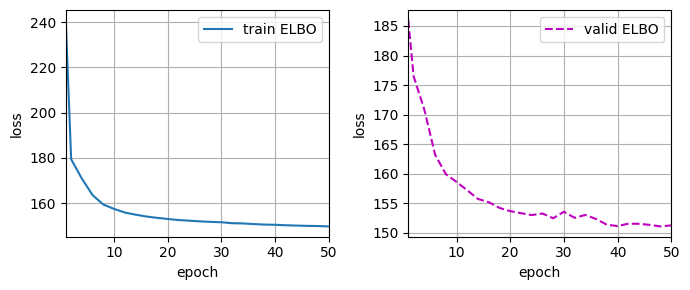

In [9]:
latent_size = 2
vae = VariationalAutoEncoder(latent_size=latent_size)
vae = ch9.train_vae(x_train, x_test, vae, Epochs=50, L=1, batch_size=256, lr=1e-3, verbose=2)

我们绘制 VAE 重构的图像与原始的图像进行对比

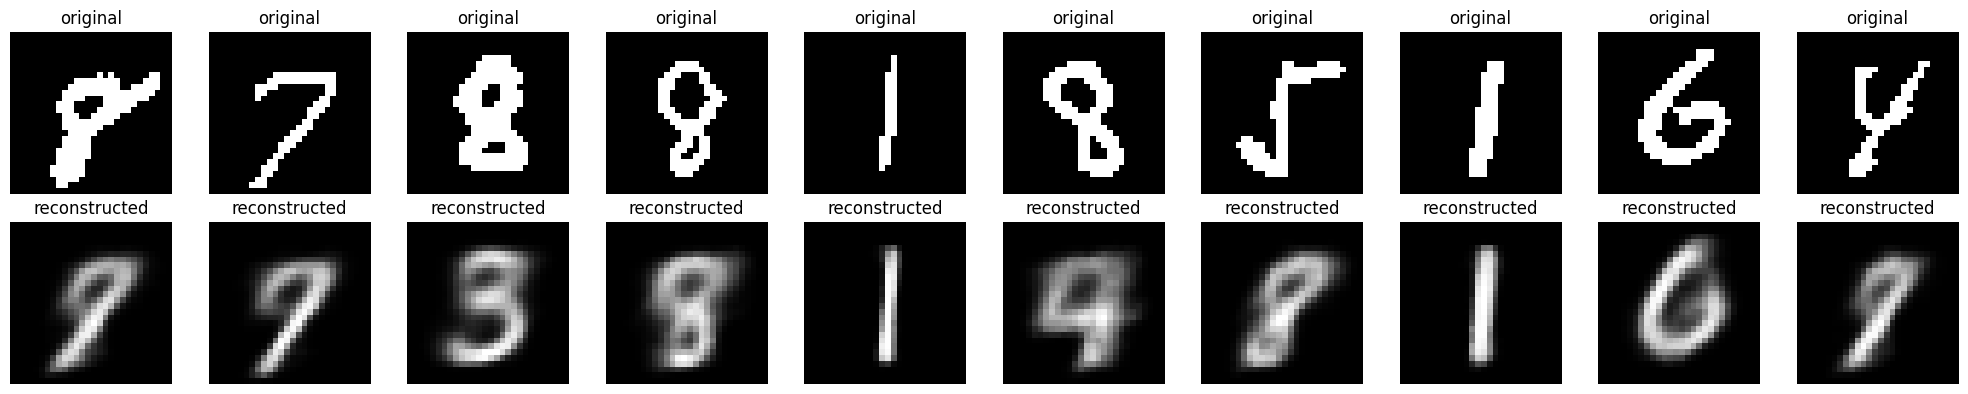

In [119]:
n_sample = 10
idx = np.random.choice(len(x_test), size=n_sample)
x_batch = x_test[idx]
x_recon = vae(x_batch).numpy()
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0][i].imshow(x_batch[i], cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(x_recon[i], cmap='gray')
    ax[1][i].axis('off')
    ax[0][i].set_title("original")
    ax[1][i].set_title("reconstructed")
plt.tight_layout()

最后，我们可视化 `MNIST` 手写数字如何随着隐向量 $\mathbf{z}$ 连续空间进行变化，由于我们设置了 `latent_size = 2`，每个数字都会在二维连续空间中变形为另一个数字，**隐向量 $\mathbf{z}$ 服从于一个二元的高斯分布**：
$$
p_\theta(\mathbf{z}) = N\left(\mathbf{z};\mathbf{0}_2, \mathbf{I}_2\right)
$$

首先，我们**用概率编码器 $q_\phi(\mathbf{z}|\mathbf{x})$ 的编码结果 $\mathbf{z}$ 来构造多分类模型**，以帮助我们获得决策边界

In [12]:
# 重新导入 MNIST 数据集，这次需要标签
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 增加通道维度，并将像素值转换为 0-1 二元值
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0
x_train = np.where(x_train > 0.5, 1.0, 0.0).astype('float32')
x_test = np.where(x_test > 0.5, 1.0, 0.0).astype('float32')

In [13]:
# 使用训练好的概率编码器，将训练集和测试集编码为隐变量
mu_train, log_var_train = vae.encoder(x_train)
mu_test, log_var_test = vae.encoder(x_test)
z_train = vae.encoder.reparameterize(mu_train, log_var_train, L=1)
z_test = vae.encoder.reparameterize(mu_test, log_var_test, L=1)

In [19]:
# 构造分类器模型
cls = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, n_jobs=-1)
cls.fit(z_train, y_train)
print("accuracy on train set: %.3f" % accuracy_score(y_true=y_train, y_pred=cls.predict(z_train)))
print("accuracy on test set: %.3f" % accuracy_score(y_true=y_test, y_pred=cls.predict(z_test)))

accuracy on train set: 0.693
accuracy on test set: 0.672


我们可以**从二维高斯分布的分位数中采样，构成 $\mathbf{z} = [z_1,z_2]$ 的网格，然后以它们作为概率解码器的输入，得到从二维隐空间到图像空间的映射结果**，同时，我们展示对应位置区域的分类模型的决策边界

In [164]:
def plot_latent_space_transform(model : tf.keras.Model, cls, n : int=20, image_size : int=28):
    """
    Parameters
    ----------
    model : tf.keras.Model
        VAE 模型
    cls : Any
        分类器，用于获得模型的决策边界
    n : int, default = 20
        网格的大小
    image_size : int, default = 28
        图像的大小
    """
    from scipy import stats
    # 生成隐变量 z 的网格
    z1_grid = stats.norm.ppf(np.linspace(0.05, 0.95, n))
    z2_grid = stats.norm.ppf(np.linspace(0.05, 0.95, n))

    image_width = image_height = n * image_size
    image = np.zeros((image_height, image_width))

    for i, z1 in enumerate(z1_grid):
        for j, z2 in enumerate(z2_grid):
            # z = [z1, z2] 作为概率解码器输入
            z = tf.constant([[z1, z2]], dtype=tf.float32)
            
            # 解码得到图像
            x_recon = model.sample(z).numpy().reshape(image_size, image_size)
            # 因为 imshow 交换了 x 和 y 轴
            # 所以这里按照 [y, x] 的顺序填充图像
            image[(n - j - 1) * image_size : (n - j) * image_size,
                  i * image_size : (i + 1) * image_size] = x_recon

    # 可视化决策边界
    z_min, z_max, step = z1_grid.min(), z1_grid.max(), 0.02
    z_1, z_2 = np.meshgrid(np.arange(z_min, z_max, step), np.arange(z_min, z_max, step))
    z_grid = np.c_[z_1.ravel(), z_2.ravel()]
    prob_dist = cls.predict(z_grid)

    # 绘制从隐空间到图像空间的映射
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax = ax.flatten()
    ax[0].imshow(image, cmap='gray')
    ax[0].set_xlabel("$z_1$", fontsize=15)
    ax[0].set_ylabel("$z_2$", fontsize=15)
    ax[0].set_xticks(np.arange(0, n*image_size, image_size) + int(image_size / 2))
    ax[0].set_xticklabels(z1_grid.round(2))
    ax[0].set_yticks(np.arange(0, n*image_size, image_size) + int(image_size / 2))
    ax[0].set_yticklabels(z2_grid.round(2))
    ax[0].set_title("latent space transform", fontsize=18)

    colors = sns.color_palette("Set3", 10)
    for i in range(10):
        sns.scatterplot(x=z_grid[prob_dist==i, 0], y=z_grid[prob_dist==i, 1], 
                        label="class %d"%(i), color=colors[i], ax=ax[1])
    ax[1].legend(loc="upper right", fontsize=15)
    ax[1].set_xlabel("$z_1$", fontsize=15)
    ax[1].set_ylabel("$z_2$", fontsize=15)
    ax[1].set_title("latent space decision boundary", fontsize=18)
    plt.tight_layout()

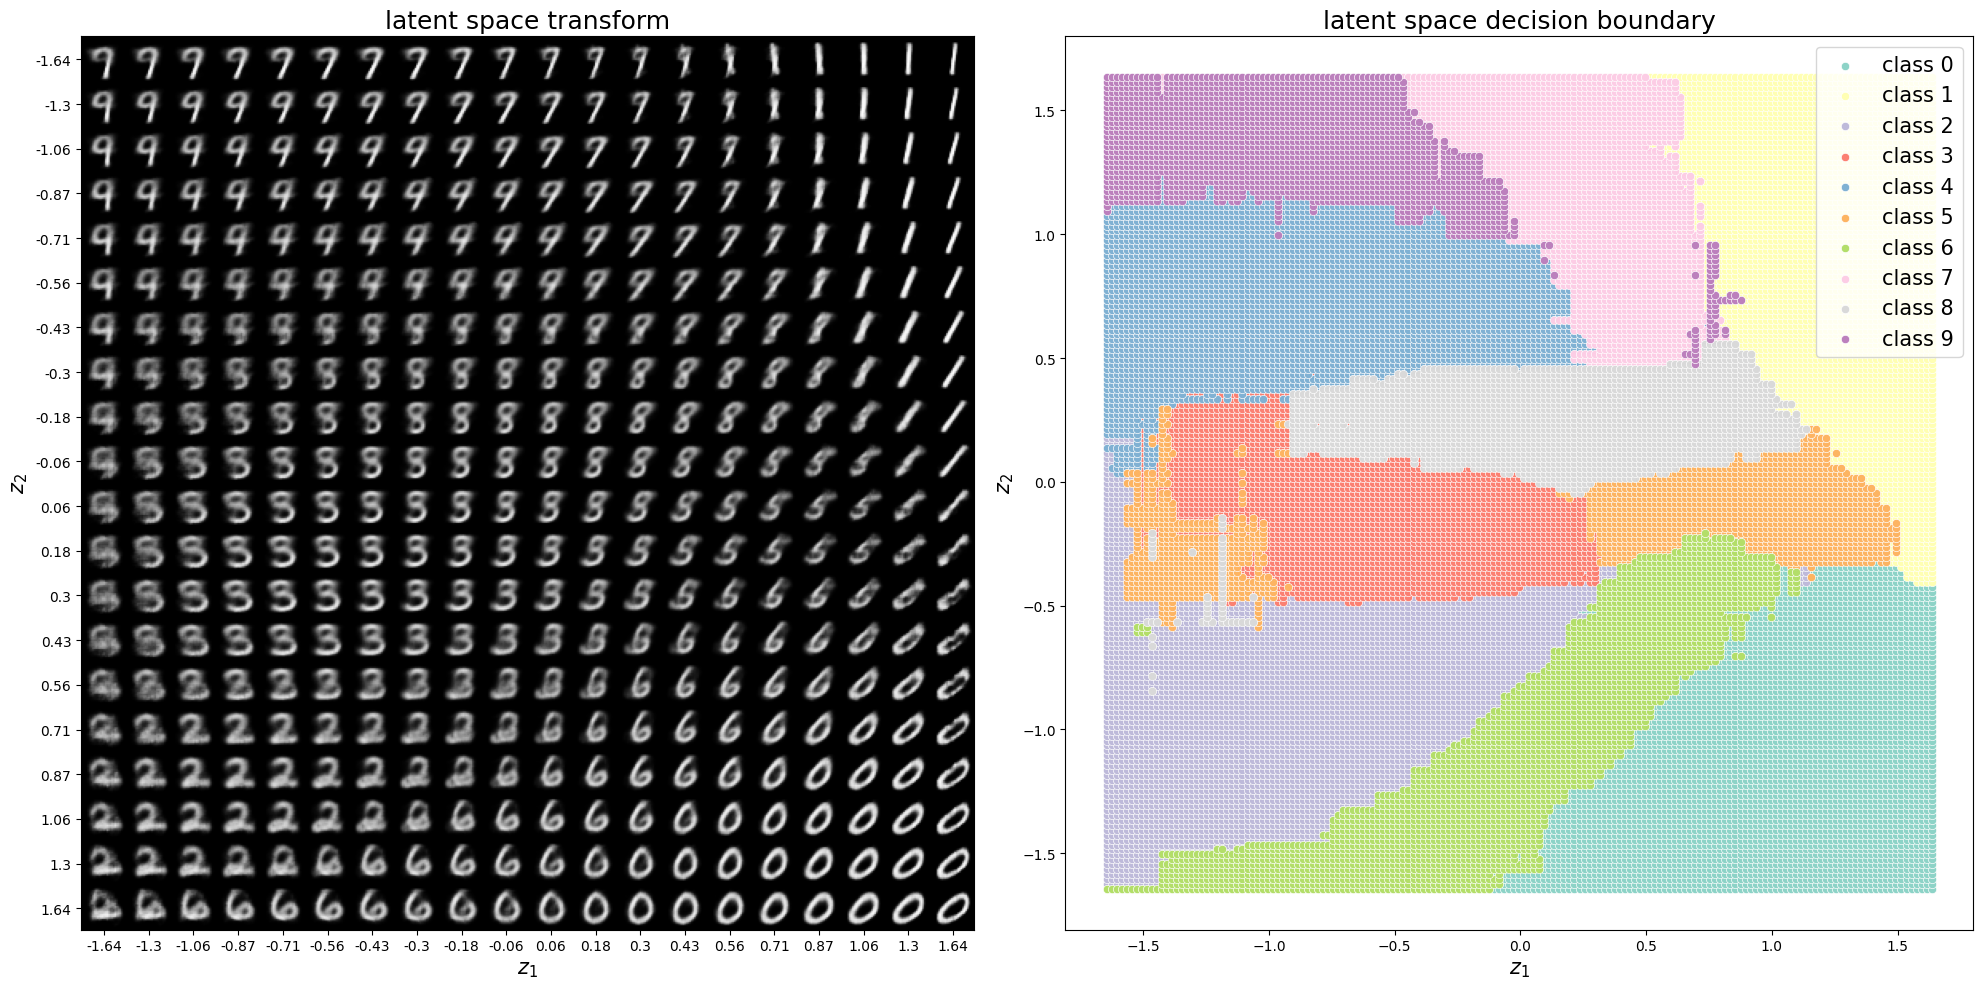

In [165]:
ch9.plot_latent_space_transform(vae, cls, n=20, image_size=28)

将 `latent_size` 设置为 2 得到的隐向量虽然损失了很多信息，**直接在 `latent_size = 2` 的隐空间中进行分类效果一般，增加 `latent_size` 可以帮助我们提升分类模型的性能，但二维的隐空间能够帮助我们清楚地看到观测样本 $\mathbf{x}$ 如何随着隐变量在低维流形中变化，同时可以观察分类模型在低维流形上的决策边界**

----